In [8]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.path.abspath("../"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools
from utilities import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load BioBank Components

In [126]:
biobank_data, biobank_index, med_code_mapping = data_tools.load_all_biobank_components()

Importing BioBank Index and Data:
Missing 0 biobank index names
UK BioBank Data Loaded.
Size: 9999 rows x 2781 columns
Elapsed time: 4.7483 seconds


Mapping ICD10 Codes: 100%|██████████| 2018/2018 [00:08<00:00, 237.42 feature/s]


# Constants

In [141]:
female_specific_cancers = ["breast cancer", "female genital tract cancer", "cervical cancer",
                           "cin/pre-cancer cells cervix", "fallopian tube cancer", "ovarian cancer",
                           "uterine/endometrial cancer", "vaginal cancer", "vulval cancer" ]

male_specific_cancers = ["male genital tract cancer", "penis cancer", "prostate cancer", "testicular cancer"]
sex_specific_cancers = female_specific_cancers + male_specific_cancers

 # Basic Summary stats

In [18]:
cancer_data = biobank_data.loc[~biobank_data["cancer_code"].isna()]

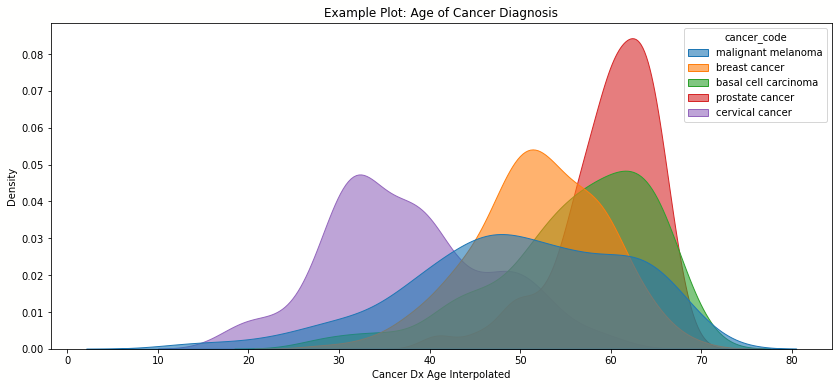

In [19]:
cancer_codes, counts = np.unique(cancer_data["cancer_code"], return_counts=True)

common_cancer_codes = cancer_codes[np.argsort(counts,)[-5:]]
common_cancer_data = cancer_data.loc[cancer_data["cancer_code"].isin(common_cancer_codes)]

fig, ax = plt.subplots(figsize=(14, 6), facecolor="#fffffe")
sns.kdeplot(data=common_cancer_data, x="cancer_dx_age_interpolated", hue="cancer_code", ax=ax,
            cumulative=False, shade=True, common_norm=False, bw_method=.35, alpha=.6)
ax.set_title("Example Plot: Age of Cancer Diagnosis")
add_plt_labels(ax, "cancer_dx_age_interpolated", "Density")
fig.savefig(constants.COVER_PLOTS_GENERIC_FILE_PATH.format("cancer_dx_age.png"), facecolor="#fffffe")

In [351]:
variables_of_interest = ["sex", "cancer_code"]

grouping_df = cancer_data[variables_of_interest].copy(deep=True)
grouping_df["total"] = grouping_df["sex"] != "nothing"
grouping_df["female"] = grouping_df["sex"] == "Female"
grouping_df["male"] = grouping_df["sex"] == "Male"
grouping_df = grouping_df.groupby("cancer_code").sum().reset_index()

grouping_df = grouping_df.loc[ ~grouping_df["cancer_code"].isin(sex_specific_cancers)]
grouping_df = grouping_df.query("total > 5").sort_values("total", ascending=False)
most_common_cancers = grouping_df["cancer_code"]

grouping_df["male_fraction"] = grouping_df["male"] / grouping_df["total"]
grouping_df["female_fraction"] = grouping_df["female"] / grouping_df["total"]
grouping_df

,cancer_code,total,female,male,male_fraction,female_fraction
1,basal cell carcinoma,91,47,44,0.483516,0.516484
22,malignant melanoma,75,41,34,0.453333,0.546667
2,bladder cancer,31,10,21,0.677419,0.322581
10,colon cancer/sigmoid cancer,30,14,16,0.533333,0.466667
39,skin cancer,27,15,12,0.444444,0.555556
25,non-hodgkins lymphoma,24,9,15,0.625000,0.375000
16,large bowel cancer/colorectal cancer,17,4,13,0.764706,0.235294
26,non-melanoma skin cancer,16,8,8,0.500000,0.500000
36,rodent ulcer,11,9,2,0.181818,0.818182
15,kidney/renal cell cancer,10,4,6,0.600000,0.400000


<ipython-input-352-c2c4216e7257>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");


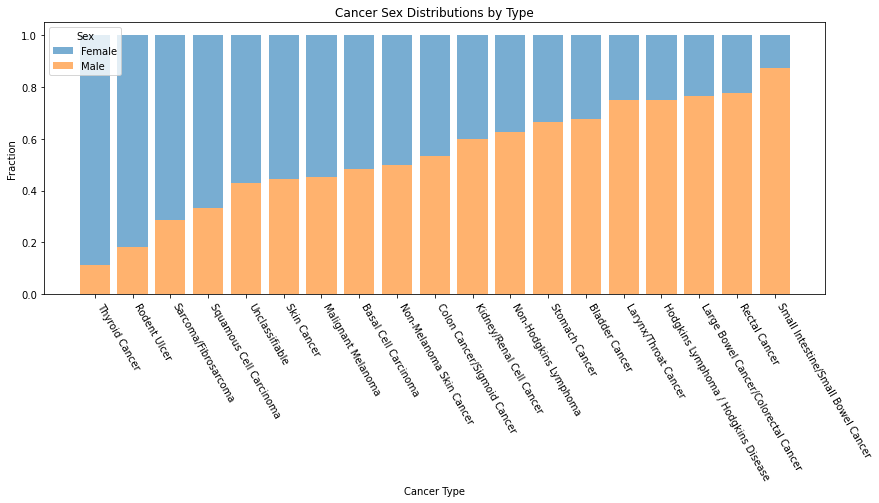

In [352]:
fig, ax = plt.subplots(figsize=(14, 5))
data = grouping_df.sort_values("male_fraction")
ax.bar(data=data, x="cancer_code", height="female_fraction",
       bottom="male_fraction", label="Female", alpha=.6)
ax.bar(data=data, x="cancer_code", height="male_fraction", label="Male", alpha=.6)
plt.draw()
add_plt_labels(ax=ax, x="Cancer Type", y="Fraction")
ax.legend(title="Sex")
ax.set_title("Cancer Sex Distributions by Type")
ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");

<ipython-input-353-9fdf28f58aa7>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");


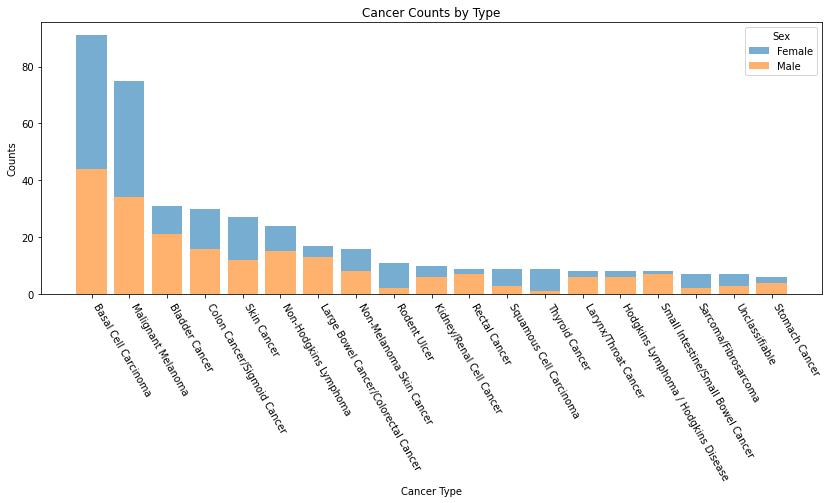

In [353]:
fig, ax = plt.subplots(figsize=(14, 5))
data = grouping_df.sort_values("total", ascending=False)
ax.bar(data=data, x="cancer_code", height="female", bottom="male", label="Female", alpha=.6)
ax.bar(data=data, x="cancer_code", height="male", label="Male", alpha=.6)
plt.draw()
add_plt_labels(ax=ax, x="Cancer Type", y="Counts")
ax.legend(title="Sex")
ax.set_title("Cancer Counts by Type")
ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");

In [397]:
data[["cancer_code", "cancer_dx_age_interpolated", "sort"]]

,cancer_code,cancer_dx_age_interpolated,sort
2369,hodgkins lymphoma / hodgkins disease,50.5499,38.6934
4921,hodgkins lymphoma / hodgkins disease,27.2641,38.6934
2673,hodgkins lymphoma / hodgkins disease,53.9148,38.6934
4848,hodgkins lymphoma / hodgkins disease,23.3050,38.6934
410,hodgkins lymphoma / hodgkins disease,50.1227,38.6934
...,...,...,...
72,small intestine/small bowel cancer,62.9937,62.9471
7978,small intestine/small bowel cancer,59.1414,62.9471
1182,unclassifiable,45.6162,64.7789
2627,unclassifiable,68.5215,64.7789


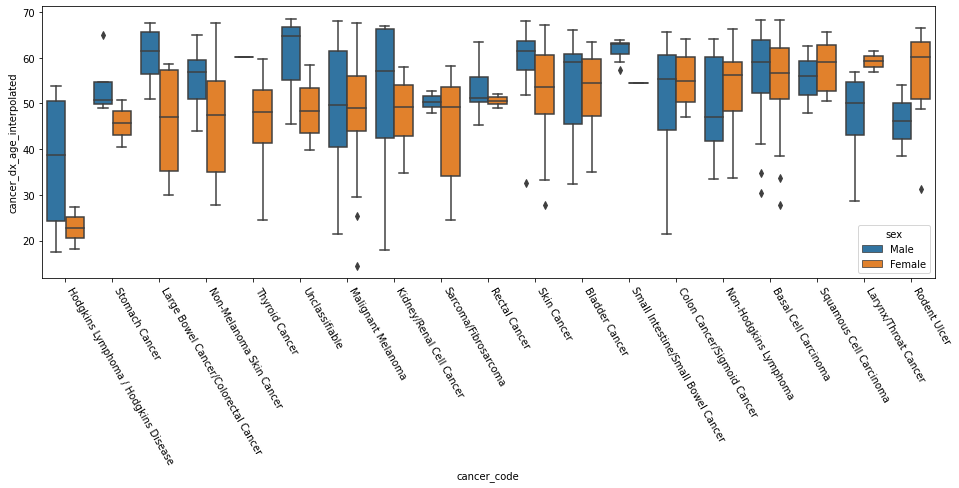

In [400]:
fig, ax = plt.subplots(figsize=(16, 5))
data = cancer_data.loc[cancer_data["cancer_code"].isin(most_common_cancers)].copy(deep=True)

sort_df = data.query("sex == 'Female'")[["cancer_dx_age_interpolated", "cancer_code"]
                                     ].groupby("cancer_code").median().reset_index()
sort_dict = dict(zip(sort_df["cancer_code"], sort_df["cancer_dx_age_interpolated"]))
sort_function = lambda key: sort_dict[key]
sort_function = np.vectorize(sort_function)

data["sort"] = data["cancer_code"].apply(sort_function)
data = data.sort_values("sort")
sns.boxplot(data=data, x="cancer_code", y="cancer_dx_age_interpolated", hue="sex", ax=ax)
ax.set_xticklabels([t._text.title() for t in ax.get_xticklabels()], rotation="-60", ha="left");

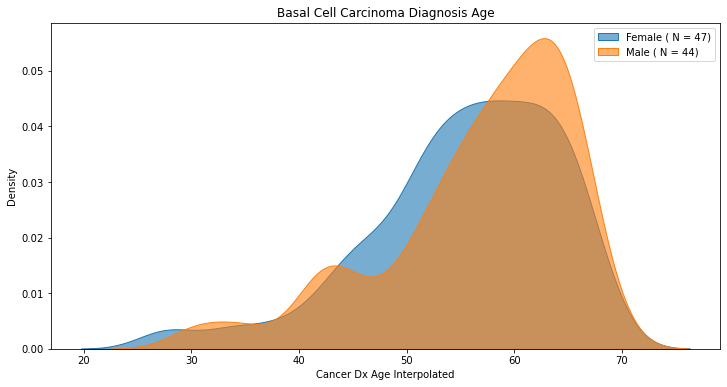

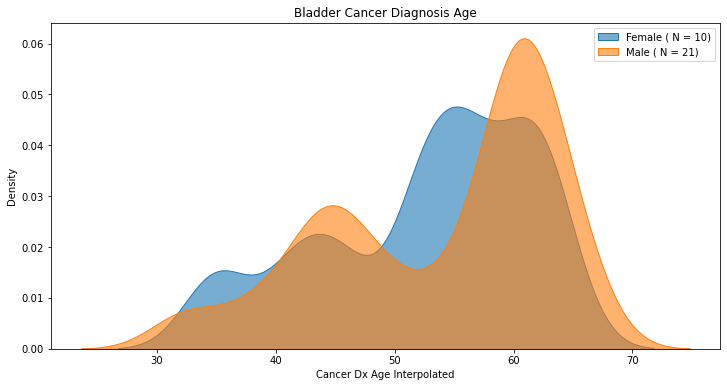

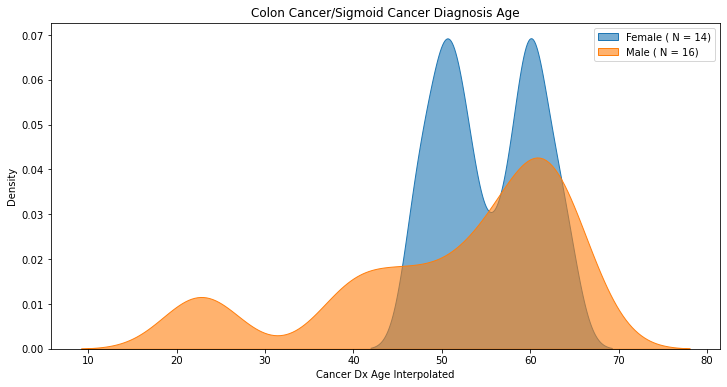

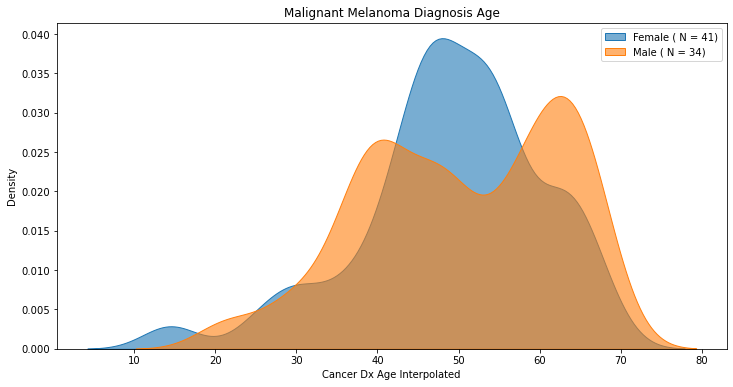

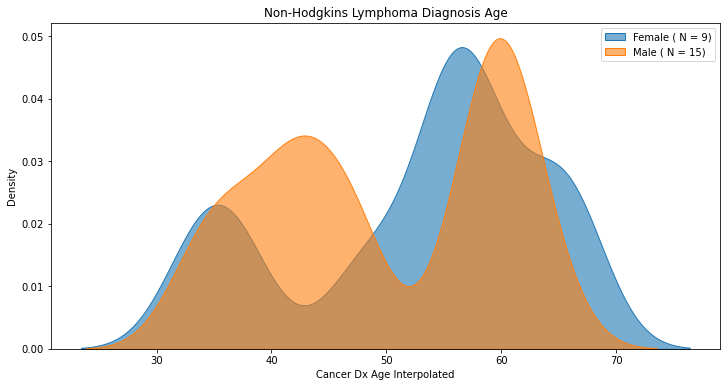

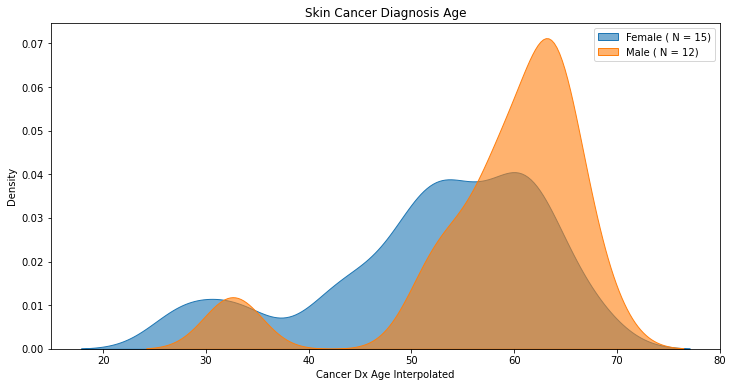

In [401]:
x, y, hue = "cancer_dx_age_interpolated", "density", "sex"
cancer_types = exclude(sorted(cancer_data["cancer_code"].unique()), sex_specific_cancers)

for cancer_code in cancer_types:
    data = cancer_data.query(f"cancer_code == '{cancer_code}'")
    counts = np.unique(data[hue], return_counts=True)[1]
    if len(data) < 20 or len(counts) <= 1:
        continue
        
    fig, ax = plt.subplots(figsize=(12, 6))
    kde_plot(data=data, x=x, hue=hue, ax=ax, bw_method=.3)
    add_plt_labels(ax, x=x, y=y)
    ax.set_title(f"{cancer_code.title()} Diagnosis Age")


# Viral Associations

In [309]:
data_tools.biobank_search(med_code_mapping, biobank_data, ("multiple sclerosis"))

,coding,meaning,code_format,name,count
134,1261,multiple sclerosis,6,illness_code,29
202,1397,other demyelinating disease (not multiple scle...,6,illness_code,1
2675,340,340 Multiple sclerosis,87,cancer_type_ICD9,0
2676,3409,3409 Multiple sclerosis,87,cancer_type_ICD9,0
3284,G35,G35 Multiple sclerosis,19,cancer_type_ICD10,0


In [ ]:
MONONUCLEOSIS_LABEL = 'infectious mononucleosis / glandular fever / epstein barr virus (ebv)'
HIV_AIDS_LABELS = "hiv/aids"


In [263]:
biobank_data.query("cancer_tumor_histology == 'SystemicEBV positive T-cell lymphoproliferative disease of childhood'")

,eid,verbal_interview_duration,verbal_interview_duration_1.0,verbal_interview_duration_2.0,sex,birth_year,bp_device,bp_device_1.0,bp_device_2.0,bp_manual_device_ID,...,operative_procedures_OPCS4_secondary_0.54,operative_procedures_OPCS4_secondary_0.55,operative_procedures_OPCS4_secondary_0.56,operative_procedures_OPCS4_secondary_0.57,important_unlabeled_34,inpatient_record_format,inpatient_record_format_0.1,inpatient_record_format_0.2,inpatient_record_format_0.3,inpatient_record_format_0.4
